# SINGLE NOTEBOOK — CNN MULTI-BLOCK NETWORK PROGRESSION

## Cell 1 — Imports & Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
from matplotlib.animation import PillowWriter

# Create output directory
os.makedirs("gifs", exist_ok=True)


## Cell 2 — Load Real Grayscale Image

In [ ]:
# Load real image (change path if needed)
img = Image.open("./Images/B.jpg").convert("L")

# Resize ONLY for visualization speed (CNN logic remains correct)
img = img.resize((64, 64))

# Normalize
x = np.array(img, dtype=float) / 255.0

print("Input shape:", x.shape)


Input shape: (64, 64)


## Cell 3 — CNN Utility Functions (SAFE)

In [3]:
def conv2d(img, kernel):
    return convolve2d(img, kernel, mode="valid")

def relu(x):
    return np.maximum(0, x)

def maxpool(x, size=2):
    h, w = x.shape

    # Trim to multiples of pool size (prevents index errors)
    h_trim = (h // size) * size
    w_trim = (w // size) * size
    x = x[:h_trim, :w_trim]

    pooled = np.zeros((h_trim // size, w_trim // size))

    for i in range(0, h_trim, size):
        for j in range(0, w_trim, size):
            pooled[i//size, j//size] = np.max(x[i:i+size, j:j+size])

    return pooled


## Cell 4 — Define Convolution Kernels

In [4]:
kernels = [
    np.array([[1, 0, -1],
              [1, 0, -1],
              [1, 0, -1]]),      # Vertical edges

    np.array([[1, 1, 1],
              [0, 0, 0],
              [-1,-1,-1]]),      # Horizontal edges

    np.array([[0, -1, 0],
              [-1, 4, -1],
              [0, -1, 0]])       # Corners
]


## Cell 5 — CNN Forward Pass (Store ALL Stages)

In [14]:
stages = []
titles = []

# Input
stages.append(x)
titles.append("Input Image")

# -------- Block 1 --------
f1 = sum(conv2d(x, k) for k in kernels)
a1 = relu(f1)
p1 = maxpool(a1)

stages.extend([np.abs(a1), p1])
titles.extend(["Conv Block 1 (|ReLU|)", "MaxPool 1"])

# -------- Block 2 --------
f2 = sum(conv2d(p1, k) for k in kernels)
a2 = relu(f2)
p2 = maxpool(a2)

stages.extend([np.abs(a2), p2])
titles.extend(["Conv Block 2 (|ReLU|)", "MaxPool 2"])

# -------- Block 3 --------
f3 = sum(conv2d(p2, k) for k in kernels)
a3 = relu(f3)

stages.append(np.abs(a3))
titles.append("Conv Block 3 (|ReLU|)")


## Cell 6 — Normalize Stages for Display

In [15]:
def normalize_stage(img, eps=1e-8):
    mn, mx = img.min(), img.max()
    if mx - mn < eps:
        return np.zeros_like(img)
    return (img - mn) / (mx - mn)



In [16]:
stages = [normalize_stage(s) for s in stages]

## Cell 7 — Grid-Based CNN Progression Animation (FAST)

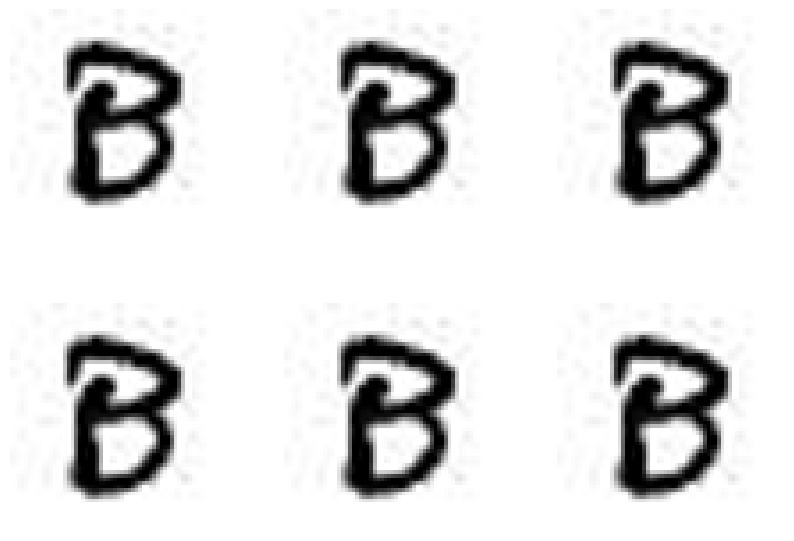

In [17]:
# Grid layout
N = len(stages)
COLS = 3
ROWS = int(np.ceil(N / COLS))

fig, axes = plt.subplots(ROWS, COLS, figsize=(10, 7))
axes = axes.flatten()

imgs = []
titles_text = []

for ax in axes:
    ax.axis("off")
    img = ax.imshow(
    stages[0],
    cmap="gray",
    vmin=0,
    vmax=1
    )
    title = ax.set_title("", fontsize=10)
    imgs.append(img)
    titles_text.append(title)

def update_grid(frame_idx):
    for i in range(frame_idx + 1):
        imgs[i].set_data(stages[i])
        imgs[i].set_clim(0, 1)   # 👈 FORCE rescale
        titles_text[i].set_text(titles[i])


## Cell 8 — FAST SAVE (NO FuncAnimation)

In [18]:
fig.set_dpi(80)

writer = PillowWriter(fps=1)

with writer.saving(fig, "gifs/cnn_full_network_progression.gif", dpi=80):
    for i in range(len(stages)):
        update_grid(i)
        writer.grab_frame()

plt.show()
